# <span style="color:#336699">Introduction to Data Science - CAP 394 [<img src="./img/icone_cap394.svg" alt="CAP394 - Introduction to Data Science" style="height:120px;" align="right">](http://www.lac.inpe.br/~rafael.santos/cap394.html)</span>


<hr style="border:2px solid #0077b9;">

   
<h1> <p align="right"> Exploratory Analysis of Meteorological Radar Dataset </p> </h1>
   
<p align='center'> Project for course  Introduction to Data Science - CAP 394</p>

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

#### Student: 
* Helvecio Leal Neto



## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [x] Preprocessing
     - [x] Cluster detection algorithm
     - [x] Relational Directions
     - [x] Create Data Functions
     - [x] Visualization Radar image
     - [x] Statistics and Results
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>
  
 <hr style="border:1px solid #0077b9;">

<a id='about'></a>
## About

<p align="justify"> <br>
This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis of radar data, gathering raw data, processing it and understanding the dynamics of cloud location from its center of mass, as well as counting the number of clusters per period.
At the end of the exploratory process it will be possible to estimate the behavior of the clouds and relate their geographical location as well as correlate average precipitation rates per hour.

<hr style="border:1px solid #0077b9;">

<a id='the_data'></a>
## The Data

<p align="justify"><br>
The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals. The dataset provides rain data over 2.5km from S-Band Radar located in lat: -3.148556, lon: -59.992000. Data dimensionality consists of a two-dimensional (241x241) matrix containing rain rate values, the Radar Radius range is approximately 240 km, covering an area of 1,500 km² over the state of Amazonas (Brazil).
<p align="justify"><br>
Overview:

"S-band radar volumes from Manaus, Brazil were shared by SIPAM for the time period beginning in January 2014 to December 2015 partially coinciding with the GOAmazon field campaign. The corrected radar reflectivity from each volume were interpolated to a fixed grid and the rainfall products were generated. A single Z-R relation (Z=174.8R^1.56) was created using 2014 wet-season impact disdrometer data and applied to the 2.5 km SIPAM Manaus S-Band CAPPI data to generate rain rates for each radar volume. This is version 2.0a of the dataset, which benefits from improved quality control procedures to remove non-meteorological data. " Schumacher</p>


https://www.arm.gov/research/campaigns/amf2014goamazon <br>

* Courtney Schumacher	S-band Radar - Rain Rates

<img src="img/SIPAM.png" align="center" alt="Drawing" style="width: 600px;">


[Figure 01: REDEMET - Radar Manaus](https://www.redemet.aer.mil.br/?i=produtos&p=radares-meteorologicos)
<hr style="border:1px solid #0077b9;">

In [2]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

#### DEFINE VARIABLES

In [3]:
PATH = 'data/radar/'
DAY = sorted(os.listdir(PATH))[0]

#### READ FIRST FILES TO LOAD GLOBAL VARIABLES

In [4]:
first_file = PATH+str(DAY)+'/'+str(sorted(os.listdir(PATH+str(DAY)))[0])
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
    
RUNIT = xds.rain_rate.units
RKM = xds.rain_rate.height_km
LON = xds.lon0.data                 ### Coordinate Longitude Matrix
LAT = xds.lat0.data                 ### Corrdinate Latitude Matrix
X0 = xds.x0                         ### Matrix of points
Y0 = xds.y0
RADAR = (np.median(LON),np.median(LAT))

#### READ TIMES

In [5]:
def read_data(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

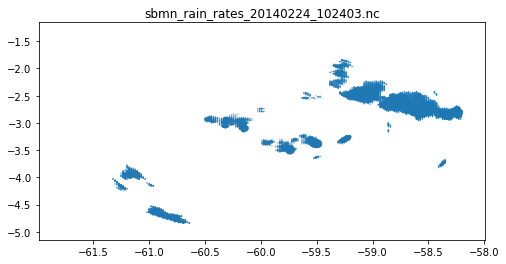

In [6]:
DAY = 20140224
figtime = 0
frames = read_data(DAY)

filename = sorted(os.listdir(PATH+str(DAY)))[figtime]
plt.figure(figsize=(8,4))
plt.title(filename)
plt.scatter(LON,LAT,frames[figtime])
plt.show();

In [989]:
def pre_processing(time):
    np.warnings.filterwarnings('ignore')
    
    ## thereshold value to track  21.8
    threshold = 21.8
    
    rs =  (np.where(time != np.nan) and np.where(time > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x1':rs[0],'y1':rs[1]})
        
    return pe

In [1008]:
def clusterization(time):
    te = time
    
    if len(te) < 2:
        return None
    
    bandwidth = estimate_bandwidth(te, quantile=0.05, n_samples=None, random_state=0, n_jobs=None)

    if bandwidth > 0:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, min_bin_freq=1,
        n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels
    
    return te

In [1009]:
day = DAY
time = 15
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))
clusters.head()

,x1,y1,cluster
0,105,163,4
1,105,164,4
2,106,163,4
3,106,164,4
4,106,165,4


In [1010]:
def tRelation(p,q):

    north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
    restricted_north =  p[1] == q[1] and  p[0] >  q[0]
    north_east       =  p[1] >  q[1] and  p[0] >  q[0]
    restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
    same_position    =  p[1] == q[1] and  p[0] == q[0]
    restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
    south_west       =  p[1] <  q[1] and  p[0] <  q[0]
    restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
    south_est        =  p[1] >  q[1] and  p[0] <  q[0]

    if north_west == True:
        return ('NW')
    if restricted_north == True:
        return ('RN')
    if north_east == True:
        return ('NE')
    if restricted_west == True:
        return ('RW')
    if same_position == True:
        return('SP')
    if restricted_east == True:
        return ('RE')
    if south_west == True:
        return ('SW')
    if restricted_south == True:
        return ('RS')
    if south_est == True:
        return ('SE')

In [1777]:
def create_data(day,time,frames,clusters):
    
    data = pd.DataFrame(columns=['DATETIME', 'N_CLUSTER','ID_CLUST','LON','LAT','R_FALL','DBZ'])
    
    ##Static Radar Coordinates Value for Topological relation
    radar = (-3.148556, -59.992000)
    
    # get values datetime
    dtime = xr.open_dataset(str(PATH)+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[time])).start_time.values
    
    lat = (LAT[clusters['x1'],clusters['y1']])
    lon = (LON[clusters['x1'],clusters['y1']])
    
    # get values from RAIN_FALL
    rfall = (frames[clusters['x1'],clusters['y1']])
    
    rlation = []
    # Calculate relation
    for i,row in clusters.iterrows():
        r = tRelation((lat[i],lon[i]),radar)
        rlation.append(r)
    
    
    data['LON'] = lon
    data['LAT'] = lat
    
    data['N_CLUSTER'] = len(clusters['cluster'].unique())
    data['ID_CLUST'] = clusters['cluster']
    data['X1'] = clusters['x1']
    data['Y1'] = clusters['y1']
    data['R_FALL'] = rfall
    data['T_RELATION'] = rlation
    data['DBZ'] = 10 * np.log10(200*data['R_FALL']**1.6)
    data['DATETIME'] = pd.to_datetime(dtime)
    
    data = data.set_index('DATETIME')
    
    # get 5 largest values from DBZ
    largest = 3
    cdata = pd.DataFrame()
    for i in range(data['N_CLUSTER'].max()):
        ct = data.loc[data['ID_CLUST'] == i]
        if ct.ID_CLUST.count() >= largest:
            cdata = cdata.append(ct)
            
    cdata['N_CLUSTER'] = len(cdata['ID_CLUST'].unique())
    cdata['ID_CLUST'] = cdata['ID_CLUST'].astype(int)
    
    del data,dtime,lat,lon,rfall,largest,ct
    
    return cdata

In [1957]:
day = DAY
time = 15
frames = read_data(day)
clusters = clusterization(pre_processing(frames[time]))
data = create_data(day,time,frames[time],clusters)
data.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1,T_RELATION
DATETIME,,,,,,,,,
2014-02-24 13:24:05,8,0,-59.812054,-3.221150,22.957708,44.785157,116,130,SE
2014-02-24 13:24:05,8,0,-59.812057,-3.203183,79.206802,53.390500,117,130,SE
2014-02-24 13:24:05,8,0,-59.794064,-3.203180,91.412819,54.386414,117,131,SE
2014-02-24 13:24:05,8,0,-59.884037,-3.185227,64.328918,51.944800,118,126,SE
2014-02-24 13:24:05,8,0,-59.812061,-3.185217,22.056072,44.506751,118,130,SE


In [1947]:
# geom = data.apply(lambda x: Point([x['LON'],x['LAT']]),axis=1)

# data = gpd.GeoDataFrame(data, geometry=geom)
# data.crs = {'init' :'epsg:4326'}
# data

In [1948]:
def create_geopoints(data,create_shp):
    
    if isinstance(data,pd.DataFrame):

        data['geometry'] = list(zip(data.LON,data.LAT))
        data.geometry = data.geometry.apply(Point)
        gdata = gpd.GeoDataFrame(data,geometry='geometry')
        gdata.crs = {'init' :'epsg:4326'}
        
        if create_shp == 1:
            dirname = gdata.index[0].isoformat()[:-9]
            dirname = dirname.replace('-','')
            timer = gdata.index[0].isoformat()[11:]
            timer = timer.replace(':','')
            if not os.path.exists('shapefiles/points/'+ str(dirname)):
                try:
                    os.makedirs('shapefiles/points/'+ str(dirname), 0o700)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
            gdata.to_file('shapefiles/points/'+ str(dirname) +'/sbmn_rain_rates_points_'+(dirname)+'_'+str(timer)+'.shp')          
    else:
        return None
    
    return gdata

In [1949]:
gdata = create_geopoints(data,1)
gdata.head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1,T_RELATION,geometry
DATETIME,,,,,,,,,,
2014-02-24 13:24:05,8,0,-59.812054,-3.221150,22.957708,44.785157,116,130,SE,POINT (-59.81205368041992 -3.221149682998657)
2014-02-24 13:24:05,8,0,-59.812057,-3.203183,79.206802,53.390500,117,130,SE,POINT (-59.81205749511719 -3.20318341255188)
2014-02-24 13:24:05,8,0,-59.794064,-3.203180,91.412819,54.386414,117,131,SE,POINT (-59.79406356811523 -3.203180074691772)
2014-02-24 13:24:05,8,0,-59.884037,-3.185227,64.328918,51.944800,118,126,SE,POINT (-59.88403701782227 -3.185227155685425)
2014-02-24 13:24:05,8,0,-59.812061,-3.185217,22.056072,44.506751,118,130,SE,POINT (-59.81206130981445 -3.185217142105103)


In [1950]:
# def centroidData(clus,create_shp):
#     if isinstance(clus,gpd.GeoDataFrame):
#         centroid = gpd.GeoDataFrame()  
#         for i in range(clus['N_CLUSTER'].max()):
#             ct = clus.loc[clus['ID_CLUST'] == i ]
#             ct = ct.loc[ct['R_FALL'] == ct['R_FALL'].max()]
#             centroid = centroid.append(ct)
            
#         if create_shp == 1:
#             dirname = centroid.index[0].isoformat()[:-9]
#             dirname = dirname.replace('-','')
#             timer = centroid.index[0].isoformat()[11:]
#             timer = timer.replace(':','')
#             if not os.path.exists('shapefiles/centroids/'+ str(dirname)):
#                 try:
#                     os.makedirs('shapefiles/centroids/'+ str(dirname), 0o700)
#                 except OSError as e:
#                     if e.errno != errno.EEXIST:
#                         raise
#             centroid.to_file('shapefiles/centroids/'+ str(dirname) +'/sbmn_rain_rates_'+(dirname)+'_'+str(timer)+'.shp')
#     else:
#         return None    
#     return centroid

In [1951]:
def create_geopoints(data,create_shp):
    
    if isinstance(data,pd.DataFrame):

        data['geometry'] = list(zip(data.LON,data.LAT))
        data.geometry = data.geometry.apply(Point)
        gdata = gpd.GeoDataFrame(data,geometry='geometry')
        gdata.crs = {'init' :'epsg:4326'}
        
        if create_shp == 1:
            dirname = gdata.index[0].isoformat()[:-9]
            dirname = dirname.replace('-','')
            timer = gdata.index[0].isoformat()[11:]
            timer = timer.replace(':','')
            if not os.path.exists('shapefiles/points/'+ str(dirname)):
                try:
                    os.makedirs('shapefiles/points/'+ str(dirname), 0o700)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
            gdata.to_file('shapefiles/points/'+ str(dirname) +'/sbmn_rain_rates_points_'+(dirname)+'_'+str(timer)+'.shp')          
    else:
        return None
    
    return gdata

In [1952]:
create_geopoints(data,0).head()

,N_CLUSTER,ID_CLUST,LON,LAT,R_FALL,DBZ,X1,Y1,T_RELATION,geometry
DATETIME,,,,,,,,,,
2014-02-24 13:24:05,8,0,-59.812054,-3.221150,22.957708,44.785157,116,130,SE,POINT (-59.81205368041992 -3.221149682998657)
2014-02-24 13:24:05,8,0,-59.812057,-3.203183,79.206802,53.390500,117,130,SE,POINT (-59.81205749511719 -3.20318341255188)
2014-02-24 13:24:05,8,0,-59.794064,-3.203180,91.412819,54.386414,117,131,SE,POINT (-59.79406356811523 -3.203180074691772)
2014-02-24 13:24:05,8,0,-59.884037,-3.185227,64.328918,51.944800,118,126,SE,POINT (-59.88403701782227 -3.185227155685425)
2014-02-24 13:24:05,8,0,-59.812061,-3.185217,22.056072,44.506751,118,130,SE,POINT (-59.81206130981445 -3.185217142105103)


In [1953]:
import heapq

def poly_data(cdata,create_shp):
    
    if isinstance(cdata,pd.DataFrame):

        m_fall = []
        m_dbz = []
        
        for i in range(cdata['N_CLUSTER'].max()):
            ct = cdata.loc[cdata['ID_CLUST'] == i ]
            tr3max = heapq.nlargest(3,ct.R_FALL.values)
            tr3dmax = heapq.nlargest(3,ct.DBZ.values)
            m_fall.append(np.asanyarray(tr3max).mean())
            m_dbz.append(np.asanyarray(tr3dmax).mean())
        
        datetime = cdata.index[0]
    
        cdata['geometry'] = list(zip(cdata.LON,cdata.LAT))
        cdata.geometry = cdata.geometry.apply(Point)
        cdata['geometry'] = cdata['geometry'].apply(lambda x: x.coords[0])
        cdata = cdata.groupby('ID_CLUST')['geometry'].apply(lambda x: Polygon(x.tolist()))
        cdata = gpd.GeoDataFrame(cdata, geometry = 'geometry')
        cdata.crs = {'init' :'epsg:4326'}
        cdata['R_FALL'] = m_fall
        cdata['DBZ'] = m_dbz

        cdata['DATETIME'] = pd.to_datetime(datetime)
        cdata['ID'] = cdata.index
        cdata = cdata.set_index('DATETIME')
        cdata['geometry'] = cdata.geometry.exterior.convex_hull
        

        if create_shp == 1:
            dirname = cdata.index[0].isoformat()[:-9]
            dirname = dirname.replace('-','')
            timer = cdata.index[0].isoformat()[11:]
            timer = timer.replace(':','')
            if not os.path.exists('shapefiles/polygons/'+ str(dirname)):
                try:
                    os.makedirs('shapefiles/polygons/'+ str(dirname), 0o700)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
            cdata.to_file('shapefiles/polygons/'+ str(dirname) +'/sbmn_rain_rates_'+(dirname)+'_'+str(timer)+'.shp')          
    else:
        return None
    
    return cdata

In [1954]:
gdata = poly_data(data,1)
gdata

,geometry,R_FALL,DBZ,ID
DATETIME,,,,
2014-02-24 13:24:05,POLYGON ((-59.81205368041992 -3.22114968299865...,78.316180,53.240571,0
2014-02-24 13:24:05,POLYGON ((-60.15392303466797 -3.02352356910705...,69.152765,51.641969,1
2014-02-24 13:24:05,POLYGON ((-59.4341926574707 -3.167117118835449...,34.900126,47.666524,2
2014-02-24 13:24:05,POLYGON ((-59.56009674072266 -3.29293990135192...,31.210044,46.906231,3
2014-02-24 13:24:05,POLYGON ((-59.21807479858398 -3.41849994659423...,37.604331,47.875508,4
2014-02-24 13:24:05,POLYGON ((-60.18981552124023 -2.50249552726745...,23.704683,44.996854,5
2014-02-24 13:24:05,POLYGON ((-59.9740104675293 -3.059468507766724...,29.705407,46.498346,6
2014-02-24 13:24:05,POLYGON ((-59.90203857421875 -3.09539723396301...,26.291951,45.707366,7


In [2004]:
def largest_3(cdata):
    if isinstance(cdata,pd.DataFrame):

        data = pd.DataFrame()

        for i in range(cdata['N_CLUSTER'].max()):
            ct = cdata.loc[cdata['ID_CLUST'] == i ]
            tr3max = heapq.nlargest(3,ct.R_FALL)
            
            for j in range(3):
                mm = cdata.loc[cdata.R_FALL == tr3max[j]]
                data = data.append(mm)
        
        return data

In [2017]:
dat = poly_data(largest_3(data),1)
dat

,geometry,R_FALL,DBZ,ID
DATETIME,,,,
2014-02-24 13:24:05,POLYGON ((-59.81205749511719 -3.20318341255188...,78.316180,53.240571,0
2014-02-24 13:24:05,POLYGON ((-60.15392303466797 -3.02352356910705...,69.152765,51.641969,1
2014-02-24 13:24:05,POLYGON ((-59.4341926574707 -3.167117118835449...,34.900126,47.666524,2
2014-02-24 13:24:05,POLYGON ((-59.56009674072266 -3.29293990135192...,31.210044,46.906231,3
2014-02-24 13:24:05,POLYGON ((-59.20007705688477 -3.41848611831665...,37.604331,47.875508,4
2014-02-24 13:24:05,POLYGON ((-60.18981552124023 -2.50249552726745...,23.704683,44.996854,5
2014-02-24 13:24:05,POLYGON ((-59.9740104675293 -3.059468507766724...,29.705407,46.498346,6
2014-02-24 13:24:05,POLYGON ((-59.90203857421875 -3.09539723396301...,26.291951,45.707366,7


In [1784]:
from shapely import wkt
def geo_data(cdata):
 
    cdata['geometry'] = list(zip(cdata.LON,cdata.LAT))
    cdata.geometry = cdata.geometry.apply(Point)
    cdata['geometry'] = cdata['geometry'].apply(lambda x: x.coords[0])
    cdata = cdata.groupby('ID_CLUST')['geometry'].apply(lambda x: Polygon(x.tolist()))
    cdata = gpd.GeoDataFrame(cdata, geometry = 'geometry')
    cdata.crs = {'init' :'epsg:4326'}
    return cdata

gdata = geo_data(data)
gdata['geometry'] = gdata.geometry.exterior
gdata.geometry.centroid.to_file('shapefiles/poly_centroid.shp')

# gdata.geometry.convex_hull.to_file('shapefiles/polygon.shp')
# gdata = gdata.buffer(0)
# gdata.to_file('shapefiles/buffer.shp')

### CREATE TIFF FILE

In [990]:
#!/usr/bin/env python
from osgeo import gdal
from osgeo import osr
import numpy as np
import os, sys

def tiff_create(day,time,frames):
    
    tiff_name = sorted(os.listdir(PATH+str(day)))[time][:-3]
    directory_name = 'tiff/'+str(day)+'/'

    if not os.path.exists(directory_name):
        os.makedirs(directory_name) 

    #  Initialize the Image Size
    image_size = (241,241)

    lat = [-5.348556,-0.948556]
    lon = [-62.192,-57.7919999]

    # set geotransform
    nx = image_size[0]
    ny = image_size[1]
    xmin, ymin, xmax, ymax = [min(lon), max(lat), max(lon), min(lat)]
    # xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
    xres = (xmax - xmin) / float(nx)
    yres = (ymax - ymin) / float(ny)
    geotransform = (xmin, xres, 0, ymax, 0, -yres)

    # create the 3-band raster file
    dst_ds = gdal.GetDriverByName('GTiff').Create(directory_name+tiff_name+'.tiff', ny, nx, 1, gdal.GDT_Float64)

    dst_ds.SetGeoTransform(geotransform)    # specify coords
    srs = osr.SpatialReference()            # establish encoding
    srs.ImportFromEPSG(4326)                # WGS84 lat/long
    dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    dst_ds.GetRasterBand(1).WriteArray(frames[time])   # write a-band to the raster
    dst_ds.FlushCache()                     # write to disk
    dst_ds = None

In [991]:
tiff_create(20140224,15,frames)

### PLOT

In [992]:
import georaster
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
import cartopy as cartopy
from matplotlib import cm, pyplot
from matplotlib import markers

In [1756]:
def plot(frame,day,zoom):
    
    # Create centroids
    frames = read_data(day)
    clusters = clusterization(pre_processing(frames[frame]))
    data = create_data(day,frame,frames[frame],clusters)
    gdata = create_geopoints(data,0)
    
    # Create Tiff
    tiff_create(day,frame,frames)
    tiff_name = sorted(os.listdir(PATH+str(day)))[frame][:-3]
    
    fpath = r"tiff/"+ str(day) + '/' + str(tiff_name) + ".tiff"
    my_image = georaster.SingleBandRaster(fpath, load_data=True)
    
    # Create Shapefile
#     centroidData(gdata,1)
    centroid_data(data,1)
    shp_point_file = sorted(os.listdir(PATH+str(day)))[frame]
    shp_point_file = ('./shapefiles/centroids/'+str(day)+'/'+shp_point_file[:-3])
    
    
    # grab limits of image's extent
    minx, maxx, miny, maxy = my_image.extent

    image = georaster.SingleBandRaster( fpath, \
                        load_data=(minx, maxx, miny, maxy), \
                        latlon=False)
        
    file = PATH+str(day)+'/'+str(sorted(os.listdir(PATH+str(day)))[frame])
    xds = xr.open_dataset(file)
    date_time = xds.start_time.data
    date_time = pd.to_datetime(date_time)

    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = zoom                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain fall mm/h'
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)
    
    clevs = [0,1,2.5,5,10,20,30,40,50,60,70,80,90,100]

    cmap_data = ['white','deepskyblue','dodgerblue','dodgerblue','dodgerblue','blue','chartreuse','limegreen','green','darkgreen','yellow',
             'gold','orange','magenta','darkmagenta','darkmagenta']
    
#     clevs = [0.08,0.16,0.25,0.40,0.63,1,1.6,2.5,4,6.3,10,16,25,40,63,100,160]
#     cmap_data = ['thistle','darkmagenta','mediumorchid','magenta','mediumblue','royalblue','darkcyan','seagreen','chartreuse','lawngreen','greenyellow','yellow','khaki','goldenrod','darkorange','red','firebrick']

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    
    b = m.readshapefile(shp_point_file, 'centroids')
    c = m.readshapefile('./shapefiles/municipios/AM_Mun97_region', 'municipios', linewidth=0.1)
    d = m.readshapefile('./shapefiles/hidro/lineaire_1km', 'hidrografia',color='peru', linewidth=1)


    print(shp_point_file)
    
    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='o',color='k', label='RADAR')

    f = m.plot(0,0, marker='v',color='red', label='Centroids '+str(b[0]), markersize=8)

    ## PRECIPTACAO
    xi, yi = m(LON, LAT)
    levels = np.arange(0,100,1)
    clevels = np.arange(40,100,50)
    cs = m.contourf(xi,yi,image.r,levels=levels, cmap = cmap, norm=norm, ax=ax)
    cs2 = m.contour(xi,yi,image.r,levels=clevels,  ax=ax, size = 20)
    
    arrowprops = dict(facecolor='red', arrowstyle="fancy",
                            ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90")
    
    for info, s in zip(m.centroids, m.centroids):    
        ax.annotate(' ', xy=(info[0],info[1]), xytext=(info[0],info[1]),
            arrowprops=arrowprops, size=25, color='k')

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, linewidth=0.0, size=(10))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, linewidth=0.0, size=(10))
    m.drawmapboundary(fill_color='lightgrey')

    # # # # Add Colorbar
    cbar = m.colorbar(cs, size='5%',pad="2%")
    cbar.set_label(label)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Latitude', labelpad=40, fontsize=15)
    plt.xlabel('Longitude', labelpad=60, fontsize=15)

    plt.savefig('radar_image/'+ sorted(os.listdir(PATH+str(day)))[frame]+'.png')

    plt.show()

./shapefiles/centroids/20140224/sbmn_rain_rates_20140224_132405


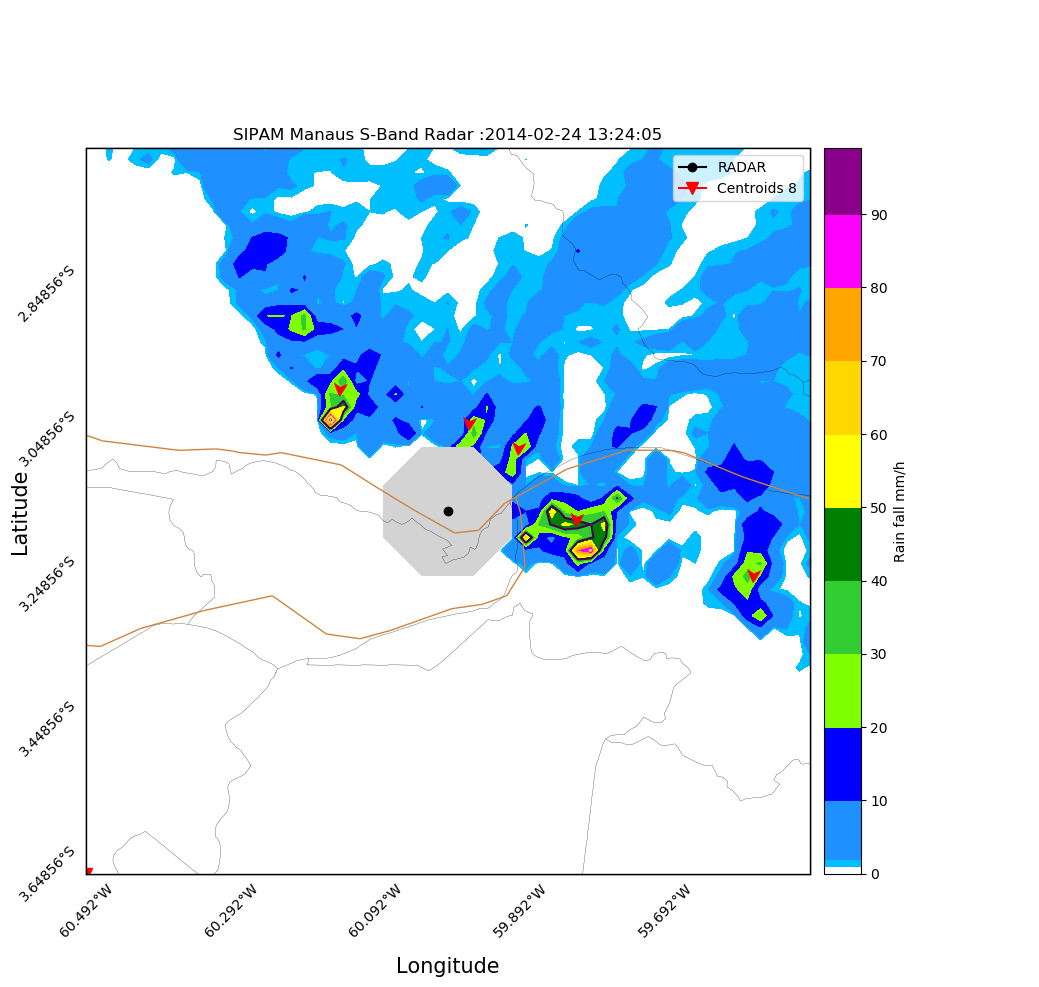

In [1757]:
day = 20140224
plot(15,day,0.5)